# Applied data analysis
## Self-confidence through quotations:



# Set the environment properly 

### Mount the Google Drive in order to access to the files which are located on our drive


In [6]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install and import every packages that will be necessary for the analysis

In [2]:
!pip install pickle-mixin
!pip install pyarrow
!pip install pathlib
!pip install contractions


import pyarrow
import pandas as pd
import numpy as np
import pathlib
from datetime import datetime
import sys
import bz2
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=6008 sha256=91543a5cec7c4331c893715250d700c214a74c5a3b673d0792ca16eddbeb3681
  Stored in directory: /root/.cache/pip/wheels/d0/70/0b/673e09a7ed429660d22352a1b117b4f616a8fc054bdd7eb157
Successfully built pickle-mixin
     |████████████████████████████████| 284 kB 8.3 MB/s 
     |████████████████████████████████| 321 kB 37.7 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85441 sha256=338a824b784d108f0ff934c3f84cc45ebc9e8a6eab630d3a5af4ab5111e750a0
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


# Preprocessing of the data



In [ ]:
# The following function allows to only keep the attributes when a single evalue is given. 
#The function replaces array of size 1 by its first element
#Indeed, some attributes are associated with an array of value, to make sure that the value we will use is the correct one, 
#we simple get rid of multiple valued element by replacing them with a 'Nan' value.

def rem_mult(array):
  if isinstance(array, np.ndarray):
    if array.size == 1 :
      array = array[0]
    else :
      array = np.nan
  return array


#### Extracting the relevant data from the original files and saving them in a new file


In [ ]:
path_to_file = '/content/drive/MyDrive/ADAprojet2021/Quotebank/quotes-2020.json.bz2' 
path_to_out = '/content/drive/MyDrive/ADAprojet2021/quotes-2020-clean.json.bz2'


quotes_size =[]
with bz2.open(path_to_out, 'wb') as d_file:
    with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample as a dictionnary
            if (instance['speaker'] != 'None' and len(instance['qids']) == 1):
              #Get rid of the quotes associated with no speaker as well as 
              # quotes associated with multiple qids
                instance_out = {}
                instance_out['speaker'] = instance['speaker']
                instance_out['qids'] = instance['qids']
                #remove [ and ] 
                instance_out['quotation'] = instance['quotation'].replace("[ ", "").replace(" ]", "")      
                size = len(instance_out['quotation'].split())
                quotes_size.append(size)
                #Add the size of the quote in our new file
                instance_out['size'] = size 
                d_file.write((json.dumps(instance_out)+'\n').encode('utf-8')) # writing in the new file
            

## First step: pre-process the quotation

  Indeed, since the whole analysis for this project is based on the quotations so it is important to keep only the quotations with comparable size


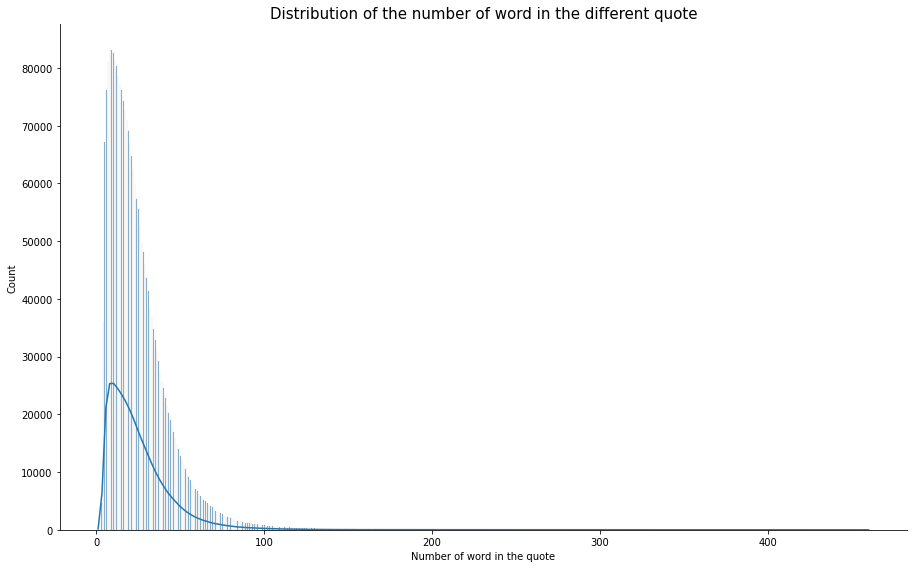

In [ ]:
#See the distribution of the quotation length:
sns.displot(data= quotes_size, kde = True, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Number of word in the quote')
plt.title("Distribution of the number of word in the different quote", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_quotes_2020.png', bbox_inches='tight')
plt.show()

According to the distribution, the majority of the quotes are at most 100-words-long. In order to make sure that we analyse complete sentences, we are only going to keep sentences in a range 5 to 100 words long.


In [ ]:
#According to the distribution of the number of word in the quotes, we can select only the quotes containg between 5 and 100 words to make sure that we analyse at least one complete sentence.

path_to_file = '/content/drive/MyDrive/ADAprojet2021/quotes-2020-clean.json.bz2'
path_to_out= '/content/drive/MyDrive/ADAprojet2021/quotes-2020-processed.json.bz2'
quotes_size1 =[]

with bz2.open(path_to_out, 'wb') as d_file:
    with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) 

            if (5<= instance['size'] <= 100):
              #We only copy the line associated with the qotation size between 5 and 100:
                instance_out = instance

                size = len(instance_out['quotation'].split())
                quotes_size1.append(size)
                d_file.write((json.dumps(instance_out)+'\n').encode('utf-8'))



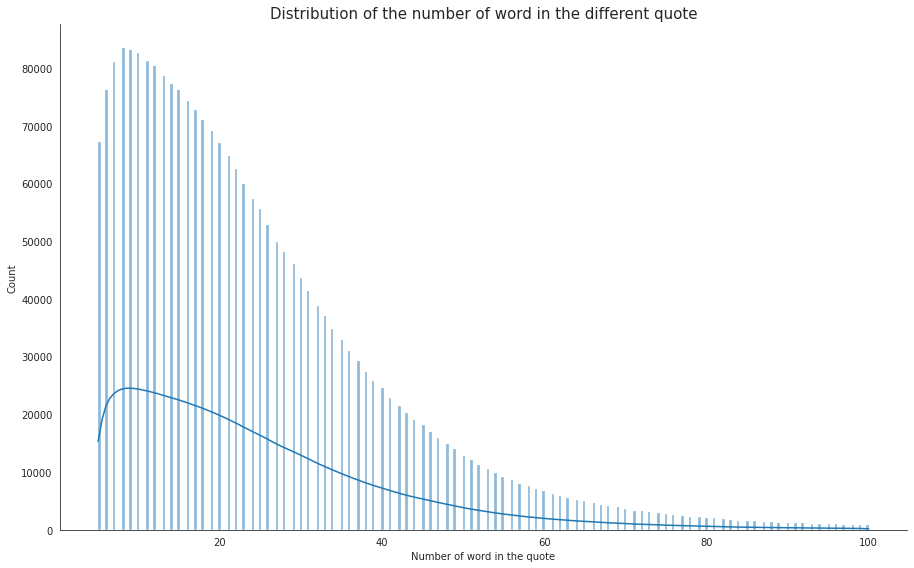

In [ ]:
sns.displot(data= quotes_size1, kde = True, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Number of word in the quote')
plt.title("Distribution of the number of word in the different quote", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_quotes_processed_2020.png', bbox_inches='tight')
plt.show()

## Second step : Pre-process the speakers attributes

During this analysis we are going to use some attributes of the speakers such as their gender, their qids ,their nationality and their US congress bio ID, if there is one.

These extracted attributes will be save in a new file.

The qIDs are kept so they will allow us to navigate between the quote file and the speaker file.

In [ ]:
#This function converts date of birth into datetime format, and replaces 
#by np.nan if speaker was born before 1900
# According to the fact that we are performing a linguistic study, it is essential to make sure that the english spoken is fairily the same. 
#To do so, we decided to select the speakers of interest regarding the date of birth. 
#Such processing makes sure that the speakers are contemporary and may speak similarily.

def dateofbirth(date):
  #Remove speakers who are born before JC
    if date[0] == '-' or date[1:5] == '0000': 
        date = np.nan
    else:
      #Notice here that we are only focusing on the year, this line will set the every birth days and months to first of january
        date = datetime.strptime(date[1:5], '%Y')
        if (date.year < 1900):
            date = np.nan
    return date

#This function removes QIDS found in the sorted data that are irrelevant for the analysis
def gender(id):
    #remove erkek (which is a last name), homosexuality 
    if id == 'Q106299064' or id == 'Q6636':
        return np.nan
    #replace male organism, cis male by male
    if id == 'Q44148' or id == 'Q15145778':
        return 'Q6581097'
    #same for female
    if id== 'Q43445' or id == 'Q15145779':
        return 'Q6581072'
    else :
        return id

#function returns true if us citizen
def us_to_bool(nat):
    if isinstance(nat, np.ndarray):
        return np.isin('Q30', nat)
    else : return False

#function returns true if in congress
def congress(id):
    if isinstance(id, str): return True
    else : return False


In [ ]:

#files = pathlib.Path('./parquet').glob('part-*-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet')
files = pathlib.Path("/content/drive/MyDrive/ADAprojet2021/Project datasets/speaker_attributes.parquet/").glob("part-*-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet")
df = pd.DataFrame()
columns = ['id', 'label', 'gender','date_of_birth', 'nationality', 'US_congress_bio_ID']
for path in files:
    df = pd.concat([df, pd.read_parquet(path, columns = columns)], join='outer', ignore_index=True)
    df = df.drop_duplicates(subset='id', keep = False)

df.gender = df.gender.apply(lambda x: rem_mult(x))
df.gender = df.gender.apply(lambda x: gender(x))

df.date_of_birth = df.date_of_birth.apply(lambda x: rem_mult(x))

df = df.dropna(subset = ['id', 'gender','date_of_birth'])
df = df.astype({'gender': 'category'})

df.date_of_birth = df.date_of_birth.apply(lambda x: dateofbirth(x))
df = df.dropna(subset = ['date_of_birth'])

df.nationality = df.nationality.apply(lambda x: us_to_bool(x))
df.US_congress_bio_ID = df.US_congress_bio_ID.apply(lambda x: congress(x))


display(df)
print(df.memory_usage(deep=True))
genders = df.gender.unique()


path_to_out = '/content/drive/MyDrive/ADAprojet2021/speaker_attributes_processed.json.bz2'
df.to_json(path_to_out, orient = 'records', compression = 'bz2') 

,id,label,gender,date_of_birth,nationality,US_congress_bio_ID
2,Q18933,Rhoda Griffis,Q6581072,1965-01-01 00:00:00,True,False
3,Q18953,Peter DeLuise,Q6581097,1966-01-01 00:00:00,True,False
4,Q18971,Arthur P. Jacobs,Q6581097,1922-01-01 00:00:00,True,False
8,Q19190,Rupert Grint,Q6581097,1988-01-01 00:00:00,False,False
9,Q19205,Rob Bourdon,Q6581097,1979-01-01 00:00:00,True,False
...,...,...,...,...,...,...
9055974,Q210228,Kozo Yuki,Q6581097,1979-01-01 00:00:00,False,False
9055975,Q210231,Hayato Sasaki,Q6581097,1982-01-01 00:00:00,False,False
9055976,Q210284,Marinaldo Cícero da Silva,Q6581097,1986-01-01 00:00:00,False,False
9055978,Q210462,Christina Hendricks,Q6581072,1975-01-01 00:00:00,True,False


Index                  25786312
id                    211539869
label                 238764324
gender                  3225420
date_of_birth         180504184
nationality             3223289
US_congress_bio_ID      3223289
dtype: int64


Since we are doing an observationnal study, it is important to have a great notion of the distribution according to the different features. 

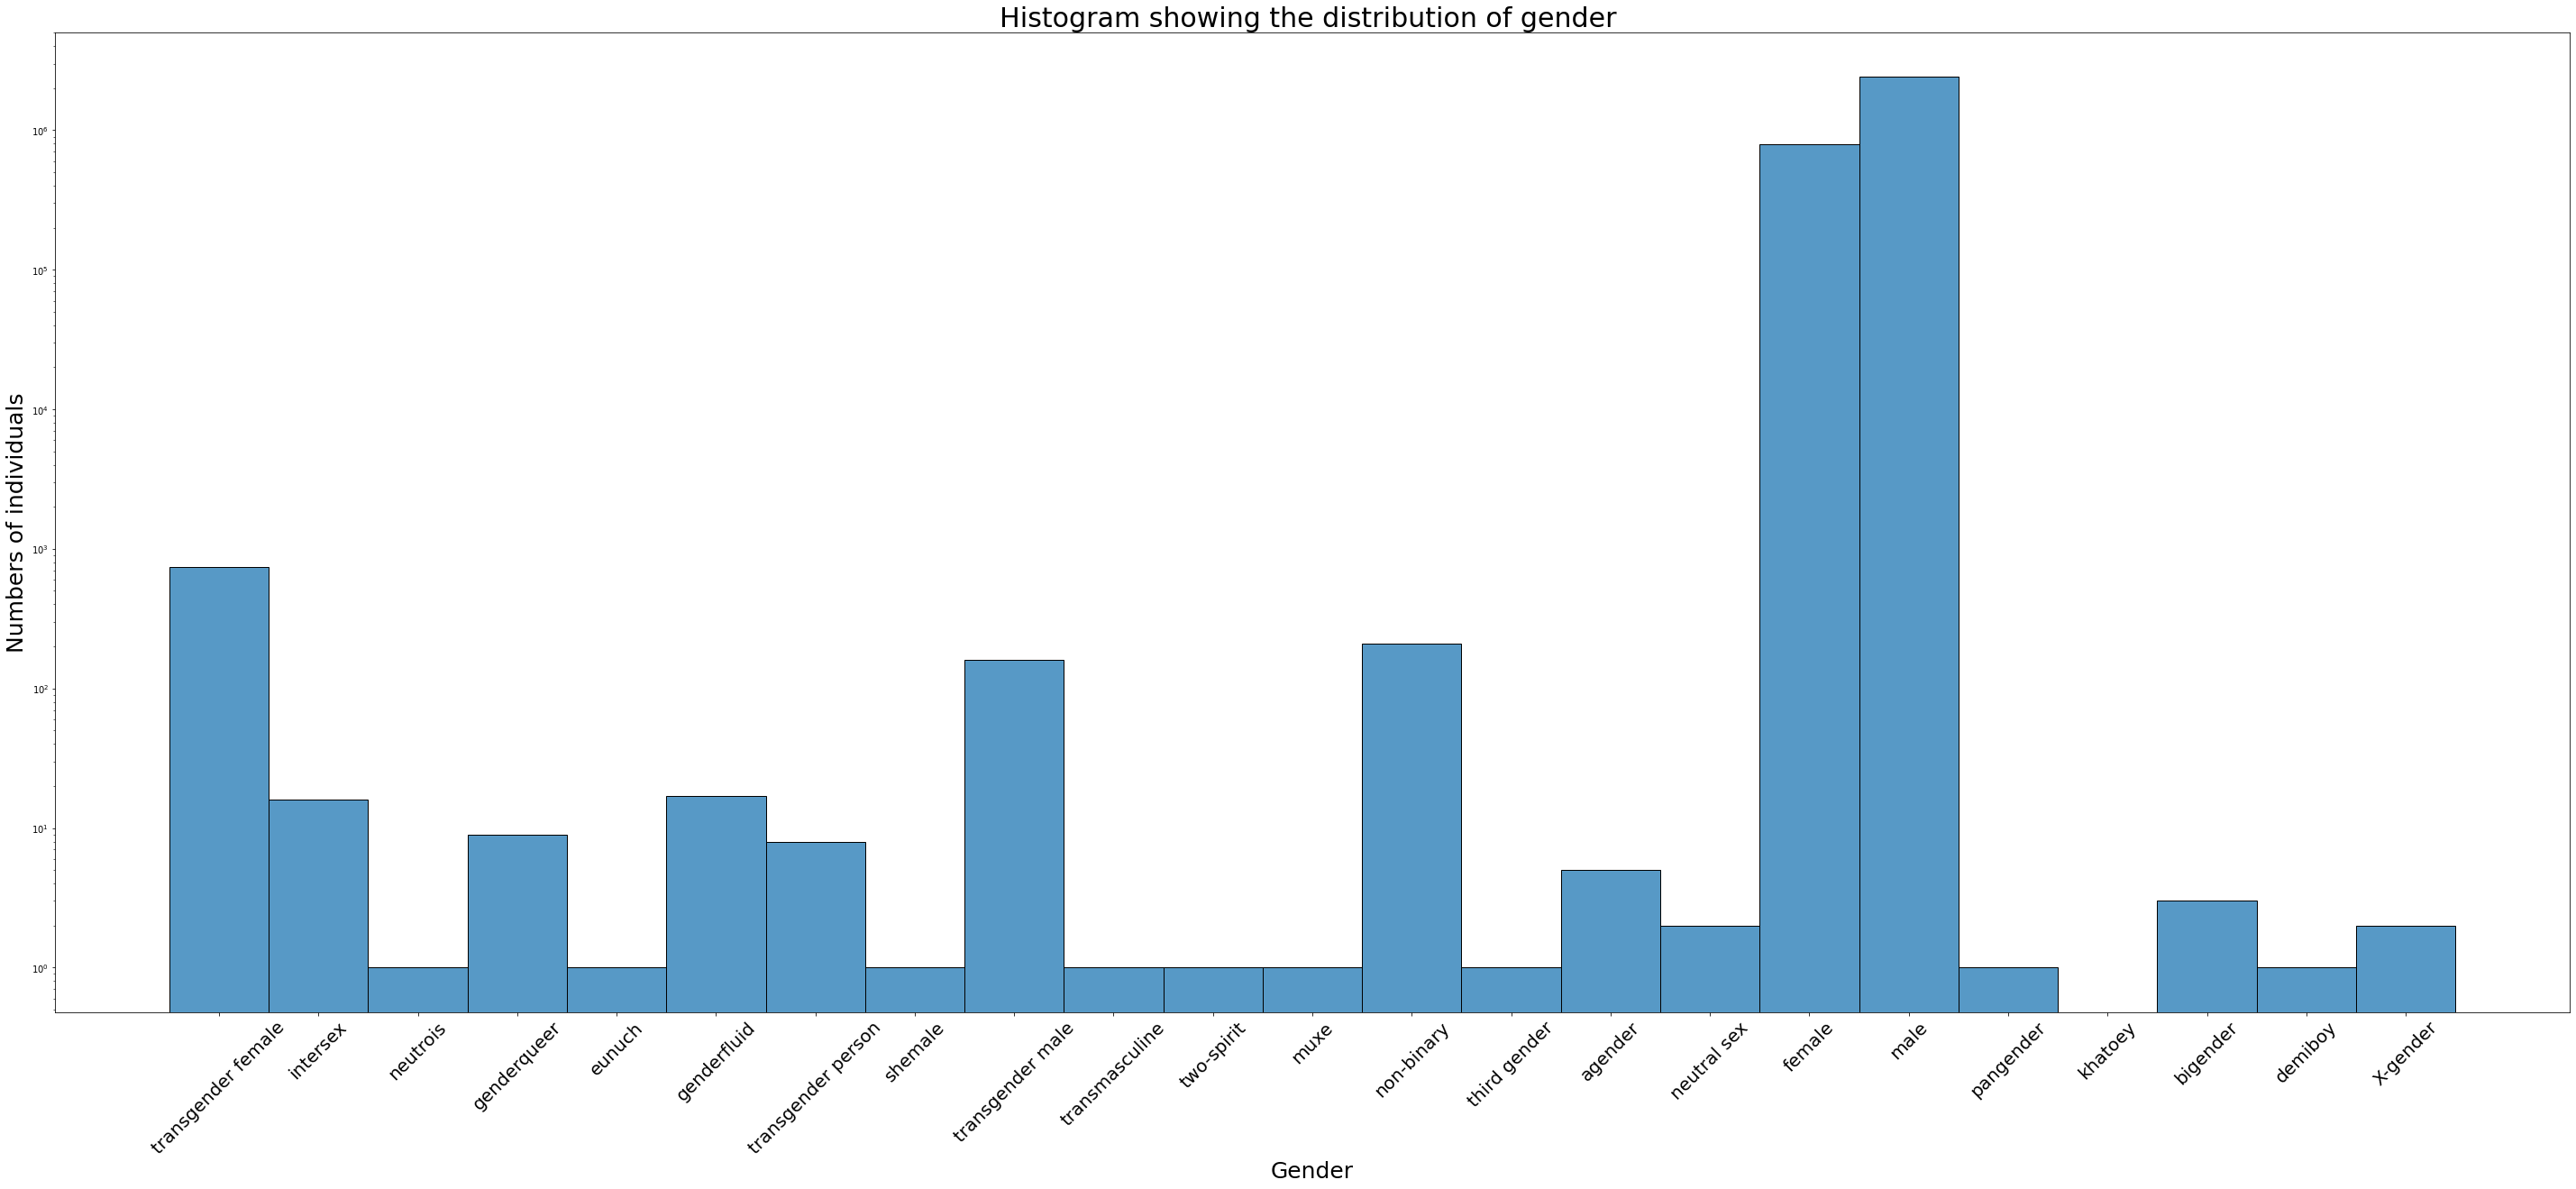

In [ ]:
plt.figure(figsize=(50,20))
sns.histplot(df.gender)
plt.title("Histogram showing the distribution of gender ", fontsize=30)
plt.xlabel("Gender", fontsize=25)
plt.ylabel("Numbers of individuals", fontsize=25)
plt.yscale('log')
labels = ['transgender female', 'intersex', 'neutrois', 'genderqueer', 'eunuch', 'genderfluid', 'transgender person', 'shemale',
          'transgender male', 'transmasculine', 'two-spirit', 'muxe', 'non-binary', 'third gender', 'agender', 'neutral sex',
         'female', 'male', 'pangender', 'khatoey', 'bigender', 'demiboy', 'X-gender']
plt.xticks(ticks = np.arange(23), labels = labels, rotation=45, fontsize=20)
plt.savefig('/content/drive/MyDrive/ADAprojet2021/hist_gender.png', bbox_inches='tight')
plt.show()

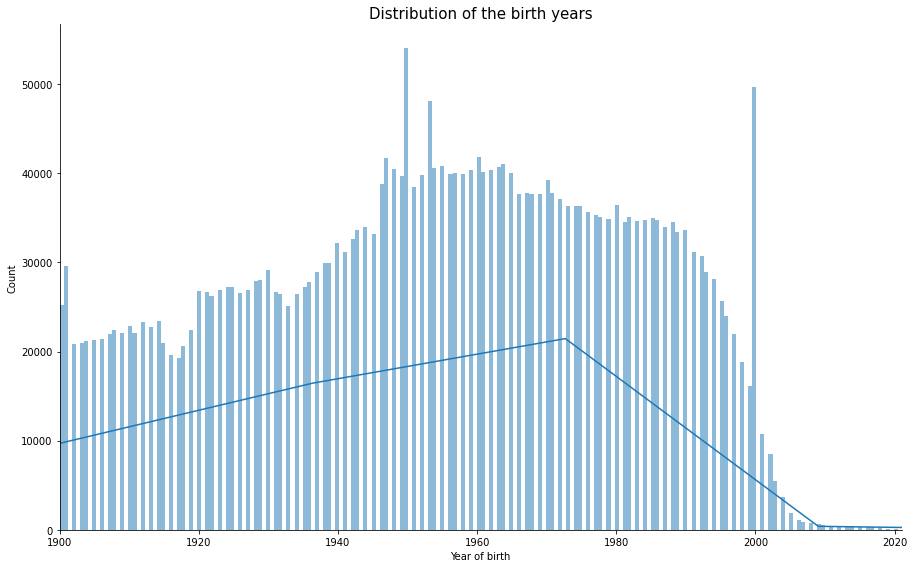

In [ ]:

x = []
for i in df.date_of_birth:
  x.append(i.year)

sns.displot(data=x, kde = True, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Year of birth')
plt.xlim(1900,2021)
plt.title("Distribution of the birth years", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_birth.png', bbox_inches='tight')
plt.show()

## Joinining both datasets
In this step, we remove quotes by speakers we removed from the speaker dataframe (e.g. because we didn't know the gender), and we count the number of quotes per speaker, so as to remove speakers that don't have quotes assigned. 

In [ ]:
#create a file merging the quotes with the speaker information, to remove quotes by speakers of which we did not have sufficient info
path_to_file = '/content/drive/MyDrive/ADAprojet2021/quotes-2020-processed.json.bz2' 
path_to_pickle = '/content/picklefile.pkl'

#function to turn the qids from the quotebank file from list to string format
def list_to_first(qids):
  return qids[0]


#We set the number of quote to zero for every speakers first
df['quote_nbr'] = np.zeros(df.shape[0])



In [ ]:
#create a file merging the quotes with the speaker information,
# to remove quotes by speakers of which we did not have sufficient info

#We open the file containing all the quotes separated in large chunks 
df_reader = pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=100000, orient = 'records')
chunk_list = []

#at the same time we are going to extract the remaining quote for NLP:
for chunk in df_reader:
    chunk.qids = chunk.qids.apply(lambda x: list_to_first(x))

    #keep only the relevant ids
    chunk = chunk[(chunk.qids).isin(df.id.tolist())]
    chunk_list.append(chunk)

    occurences = chunk.qids.value_counts()
    occurences = pd.DataFrame(occurences)
    occurences['id'] = occurences.index.to_series()
    occurences.columns = ['quote_nbr', 'id']
    df = pd.merge(df, occurences, on='id', how='left' )
    df['quote_nbr'] = df.pop('quote_nbr_x')+ df.pop('quote_nbr_y')

#we only keep quotations as well as the qids of the speaker associated with them
quotes = pd.concat(chunk_list)[['qids','quotation']]

In [ ]:
#save the final speaker file into a pickle
df.to_pickle('/content/drive/MyDrive/ADAprojet2021/speakers_info.pkl', 'bz2')


In [13]:
#Make sur that the pickle was properly saved:
print(pd.read_pickle('/content/drive/MyDrive/ADAprojet2021/quotes_info_2020.pkl','bz2'))

              qids  ... score_max
45        Q6274563  ...  0.580000
50        Q7493177  ...  0.580000
178      Q21061798  ...  0.580000
220       Q8064960  ...  0.580000
265        Q289365  ...  0.665714
...            ...  ...       ...
2451812       Q567  ...  0.580000
2451822     Q42311  ...  0.580000
2451879     Q22686  ...  0.580000
2451902  Q16234907  ...  0.580000
2451938   Q3809926  ...  0.508571

[135648 rows x 8 columns]


# Natural language processing:

Preprocessing of the citations: Put them in the right format, extract the tense of the citation to properly assign the right score.


In [ ]:
#NLP libraries
import spacy, nltk, gensim, sklearn
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.text import Text
import re 
import warnings; warnings.simplefilter('ignore')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Expression that we want to target in the citations and their associated score:

# Processing of the expressions of confidence for comparison


In [ ]:
#sentences and associated scores to be used as starting point (taken from the Wesson & Pulford paper)
sentences = pd.DataFrame(columns = ['sentence', 'score_present','score_past'])


#We also removed phrases that were in two parts (I think ... isn't it, I think ... but I can't be sure)
sentences.sentence = ["I'm absolutely certain", "I'm positive", "I'm certain", "I know for a fact", "I know", "I'm confident", "I have no doubt", "I'm sure", "I have no doubt, I mean I'm sure", "I'm fairly confident", "I remember", "I believe", "I would say", "I suspect", "I could be mistaken but I'm sure", "I think", "I'm not completely confident, but I think", "I can't say for sure, but", "I think ... but I can't be sure", "I'm not certain but","I'm not sure but","... I think", "I guess", "I could be wrong, but I think", "I think, I think", "I think ... isn't it", "I'm guessing, but I would say", "I suppose", "Oh, I don't know, I suppose", "I'm not sure, it's kind of ..."]




Process the citation to have them in a convenient format:


In [ ]:
#score in the article follow uk grading system (0-7, 7 being the best). 
sentences.score_present = [6.61, 6.57, 6.55, 6.5, 6.45, 6.43, 6.3, 6.02, 5.95, 5.32, 5.18, 4.86, 4.7, 4.68, 4.68, 4.66, 4.2, 4.16, 4.16, 4.14, 3.84, 3.75, 3.75, 3.68, 3.61, 3.48, 3.39, 3.34, 3.02, 2.91]
sentences.score_past = [6.33, 5.96, 5.90, 6.25, 6.08, 6.06, 5.88, 5.52, 5.40, 5.25, 5.25, 4.56, 4.29, 4.25, 4.17, 4.06, 4.12, 3.81, 3.48, 3.65, 3.44, 3.40, 3.56, 3.67, 3.19, 3.08, 2.92, 3.13, 2.94, 2.88]

#We change this to a 0-1 scale, as it is more intuitive. 
sentences.score_present = sentences['score_present'].apply(lambda x: x/7)
sentences.score_past = sentences['score_past'].apply(lambda x: x/7)




,sentence,score_present,score_past
0,i'm absolutely certain,0.944286,0.904286
1,i'm positive,0.938571,0.851429
2,i'm certain,0.935714,0.842857
3,i know for a fact,0.928571,0.892857
4,i know,0.921429,0.868571
5,i'm confident,0.918571,0.865714
6,i have no doubt,0.900000,0.840000
7,i'm sure,0.860000,0.788571
8,"i have no doubt, i mean i'm sure",0.850000,0.771429
9,i'm fairly confident,0.760000,0.750000


Due to the fact that some expressions are separated into two parts we decided to throw them out of the sentenced used for the comparison. We decided to also get rid of the expression that will probably won't appear in the quotes


In [ ]:
sentences = sentences[sentences.sentence != "I think ... isn't it"]
sentences = sentences[sentences.sentence != "I think ... but I can't be sure"]
sentences = sentences[sentences.sentence != "... I think"]
sentences = sentences[sentences.sentence != "I think, I think"]
sentences = sentences[sentences.sentence != "I'm not sure, it's kind of ..." ]


,sentence,score_present,score_past
0,i'm absolutely certain,0.944286,0.904286
1,i'm positive,0.938571,0.851429
2,i'm certain,0.935714,0.842857
3,i know for a fact,0.928571,0.892857
4,i know,0.921429,0.868571
5,i'm confident,0.918571,0.865714
6,i have no doubt,0.900000,0.840000
7,i'm sure,0.860000,0.788571
8,"i have no doubt, i mean i'm sure",0.850000,0.771429
9,i'm fairly confident,0.760000,0.750000


To make sure that the expression will be recognized, we explicit the verb that are truncated e.g "I'm" and "I am"

In [ ]:
import contractions

#this function allows to expand rhe contracted verb, it returns the expanded form as well as the score associated with it. 
#since the expanded form has the exat meaning, we kept the same score

def expanded_form(exp):

  expanded_words = []
  for word in exp.split():
    expanded_words.append(contractions.fix(word))
  expanded_text = ' '.join(expanded_words)

  return({'sentence': contractions.fix(expanded_text), 'score_present': sentences[sentences.sentence == exp].score_present.item(), 'score_past':sentences[sentences.sentence == exp].score_past.item()})



In [ ]:
#Now we add those expanded form of expression in the original set on sentences 
for expanded in sentences['sentence'].apply(lambda x: expanded_form(x)):
  sentences = sentences.append(expanded, ignore_index=True)

#since some expressions didn't need to be expanded there are duplicated, s we get rid of those
sentences = sentences.drop_duplicates()

#to enable proper comparison we need to case fold the expressions to avoid a missing
sentences.sentence = sentences['sentence'].apply(lambda x: x.casefold())
display(sentences)

,sentence,score_present,score_past
0,i'm absolutely certain,0.944286,0.904286
1,i'm positive,0.938571,0.851429
2,i'm certain,0.935714,0.842857
3,i know for a fact,0.928571,0.892857
4,i know,0.921429,0.868571
5,i'm confident,0.918571,0.865714
6,i have no doubt,0.900000,0.840000
7,i'm sure,0.860000,0.788571
8,"i have no doubt, i mean i'm sure",0.850000,0.771429
9,i'm fairly confident,0.760000,0.750000


# Cellule pour generer des dataframe tests

Je laisse la cellule qui genere un data frame test si quelqu'un a besoin d'un sous ensemble pour tester ses trucs

In [ ]:
#Extract a small part of the whole file to test 
path = '/content/drive/MyDrive/ADAprojet2021/quotes-2020-processed.json.bz2'
test = pd.DataFrame(columns=('qids','quotation', 'findings', 'score'))
i = 0
with bz2.open(path, 'rb') as s_file:
  for instance in s_file:
    instance = json.loads(instance) 
    i = i + 1
    test = test.append({'qids': instance['qids'], 'quotation': instance['quotation']}, ignore_index=True)
    if i == 15:
      break


In [ ]:
#sous ensemble expression-score de test
test_exp = pd.DataFrame(columns = ['sentence', 'score_past', 'score_present'])
test_exp.score_present = ['1','2','3','4','5']
test_exp.score_past = ['-1','-2','-3','-4','-5']
test_exp.sentence = ['is', 'not', 'why', 'the', 'of']
display(test_exp)

,sentence,score_past,score_present
0,is,-1,1
1,not,-2,2
2,why,-3,3
3,the,-4,4
4,of,-5,5


# Find the expressions of confidence in the quotations


In [ ]:
#put the different expression in a format enable multiple comparison:
rx = r"(?=\b({})\b)".format("|".join(map(re.escape, sorted(sentences.sentence, key=len, reverse=True))))
pattern = re.compile(rx)

#create an array containing the tags associated with the tense 
present = ["VBP", "VBZ","VBG"]
past = ["VBD", "VBN"]


In [ ]:
path = '/content/drive/MyDrive/ADAprojet2021/quotes-2019-processed.json.bz2'
quotes = pd.DataFrame()


with bz2.open(path, 'rb') as s_file:
  for instance in s_file:
    instance = json.loads(instance)  
    #to enable proper comparison we need to case fold the citations to avoid a missing
    quotation = instance['quotation'].casefold()
    if re.findall(pattern, quotation):
    #and np.isin(instance['qids'], speaker.id.tolist()):
      instance_out = instance
      quotes = quotes.append(instance_out, ignore_index=True)


quotes.to_pickle('/content/drive/MyDrive/ADAprojet2021/quotes_found_2019.pk1', 'bz2')


## Joinining both datasets
In this step, we remove quotes by speakers we removed from the speaker dataframe (e.g. because we didn't know the gender), and we count the number of quotes per speaker, so as to remove speakers that don't have quotes assigned. 


In [ ]:
#create a file merging the quotes with the speaker information, to remove quotes by speakers of which we did not have sufficient info

#function to turn the qids from the quotebank file from list to string format
def list_to_first(qids):
  return qids[0]

#open the files necessary for the following step :
speaker = pd.read_pickle('/content/drive/MyDrive/ADAprojet2021/final_variables/speaker_attributes_processed.pk1', 'bz2')
quotes = pd.read_pickle('/content/drive/MyDrive/ADAprojet2021/quotes_found_2020.pk1', 'bz2')

pickle_file = open('/content/drive/MyDrive/ADAprojet2021/quotes_final_2020.pk1', wb)
#create a file merging the quotes with the speaker information,
# to remove quotes by speakers of which we did not have sufficient info

chunk_list = []

#We open the file containing all the quotes separated in large chunks :

for chunk np.array_split(quotes, 10000):
    chunk.qids = chunk.qids.apply(lambda x: list_to_first(x))
    #keep only the relevant ids
    chunk = chunk[(chunk.qids).isin(speaker.id.tolist())]
    chunk_list.append(chunk)
    pickle.dump(chunk, pickle_file)
    

#we only keep quotations as well as the qids of the speaker associated with them
quotes.to_pickle('/content/drive/MyDrive/ADAprojet2021/quotes_final_2020.pk1', 'bz2')

Some expressions take into account the tense of the sentences, hence we create a new column that indicates the tense in order to properly assess the score 

In [ ]:
quotes = pd.read_pickle('/content/drive/MyDrive/ADAprojet2021/quotes_final_2020.pk1')
chunk_list = []

for chunk in np.array_split(quotes, 10000):

  #keep the expressions found in an array to allow score assessing:
  chunk['findings'] = chunk['quotation'].apply(lambda x: np.unique(re.findall(pattern, x)))

  #We compare the tags obtained with the tense vector to assess a tense to tue quotes
  chunk['tags'] = chunk['quotation'].apply(lambda x: [pos for word,pos in nltk.pos_tag(nltk.word_tokenize(x)) if np.isin(pos, past + present)])

  chunk['tense'] = chunk['tags'].apply(lambda x: 'present' if set(x).issubset(set(present)) == True else 'past' )
  chunk_list.append(chunk)

quotes_info =  pd.concat(chunk_list)[['qids','quotation', 'findings', 'tags', 'tense']]
quotes_info.to_pickle('/content/drive/MyDrive/ADAprojet2021/quotes_info_2020.pkl', 'bz2')


In [12]:
#Now that we have both time and expressisons of confidence, we compare theses expressions with the different quotes and extract the expressions found as weel as the score associated to them.

quotes.loc[quotes["tense"] == 'present', 'score'] = quotes[quotes.tense == 'present']['findings'].apply(lambda x: [float(sentences['score_present'][ind]) for ind in sentences.index if(sentences['sentence'][ind] in x)])
quotes.loc[quotes["tense"] == 'past', 'score'] = quotes[quotes.tense == 'past']['findings'].apply(lambda x: [float(sentences['score_past'][ind]) for ind in sentences.index if(sentences['sentence'][ind] in x)])

display(quotes)

FileNotFoundError: ignored

In [ ]:
#If we decide to define the quote score by averaging the values in the score array: 

quotes['score_mean'] = quotes['score'].apply(lambda x: np.mean(x))
quotes['score_std'] = quotes['score'].apply(lambda x: np.std(x))


#If we decide todefine the quote score by taking the maximum value 
#to handle empty score arrays, we initiate the minimum value of an output element to 0. It means that for empty vector the function will return zero.
quotes['score_max'] = quotes['score'].apply(lambda x: np.amax(x, initial=0))

quotes.to_pickle('/content/drive/MyDrive/ADAprojet2021/quotes_info_2020.pkl', 'bz2')
display(quotes)

,qids,quotation,findings,tags,tense,score
0,Q367796,department of homeland security was livid and ...,[],"[VBD, VBD, VBD]",past,[]
1,Q20684375,i met them when they just turned 4 and 7. they...,[],"[VBD, VBD, VBD, VBD]",past,[]
2,Q5268447,the delay will have an impact on slough but th...,[],"[VBN, VBP, VBG, VBZ]",past,[]
4,Q816459,these actions will allow households who have a...,[],"[VBP, VBG]",present,[]
5,Q30164281,1. fm is entitled to go straight to press conf...,[],"[VBZ, VBN, VBZ, VBZ]",past,[]
...,...,...,...,...,...,...
2451956,Q1407955,you sometimes have to make tough decisions tha...,[],"[VBP, VBP]",present,[]
2451957,Q495980,you understood the structure of our story and ...,[],[VBP],present,[]
2451959,Q6279,you're going to take care of the gun problem w...,[],"[VBP, VBG, VBP, VBG, VBZ]",present,[]
2451960,Q18115465,"you're seeing a young team that's maturing, th...",[],"[VBP, VBG, VBZ, VBZ, VBP, VBG, VBG, VBZ]",present,[]


# Data visualization

In [185]:
from scipy.stats import ttest_ind
!pip install statannot
from statannot import add_stat_annotation

In [23]:
quotes = pd.read_pickle('/content/drive/MyDrive/ADAprojet2021/quotes_info_2020.pkl', 'bz2')
speaker = pd.read_pickle('/content/drive/MyDrive/ADAprojet2021/final_variables/speaker_attributes_processed.pk1', 'bz2')

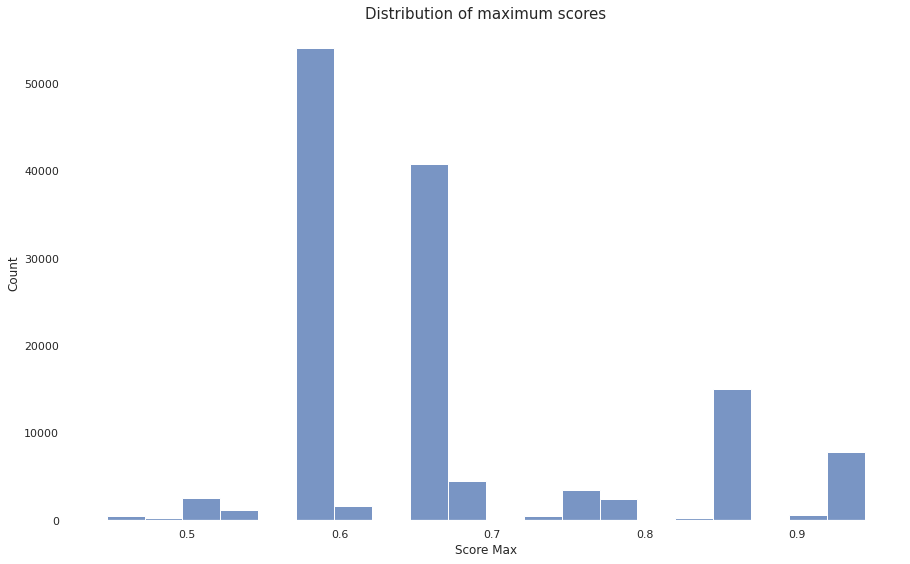

In [182]:
sns.displot(data=quotes.score_max, bins = 20,  height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Score Max')
plt.title("Distribution of maximum scores", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
fig.set_figheight(6)
plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_max_score_2020.png', bbox_inches='tight')
plt.show()

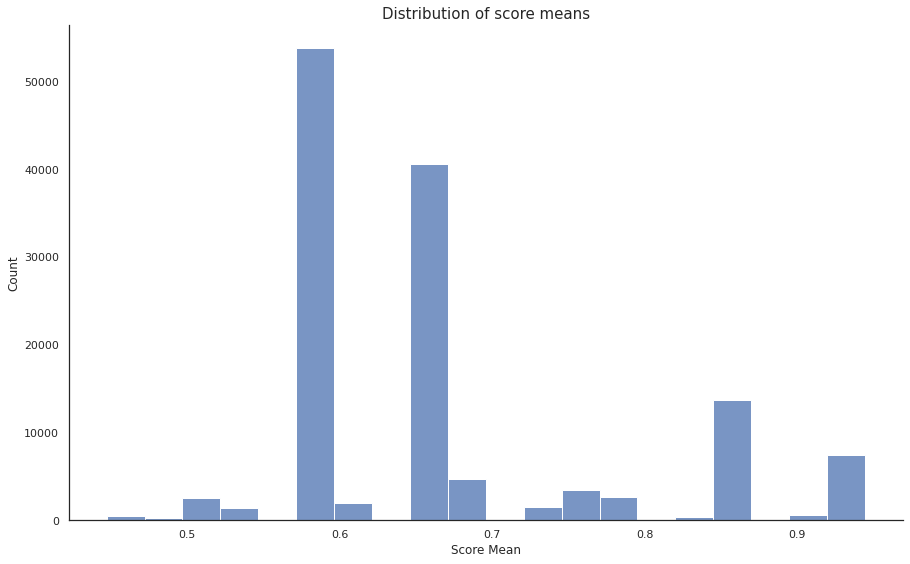

In [183]:
sns.displot(data=quotes.score_mean, bins = 20,  height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Score Mean')
plt.title("Distribution of score means", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
fig.set_figheight(6)
plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_mean_score_2020.png', bbox_inches='tight')
plt.show()

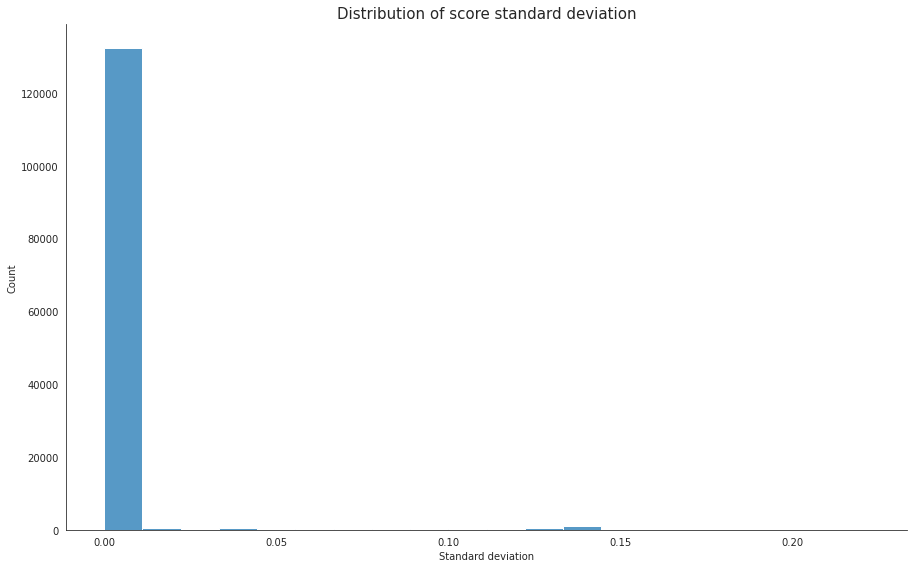

In [112]:
sns.displot(data=quotes.score_std, bins = 20, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Standard deviation')
plt.title("Distribution of score standard deviation", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
fig.set_figheight(6)
plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_std_2020.png', bbox_inches='tight')
plt.show()

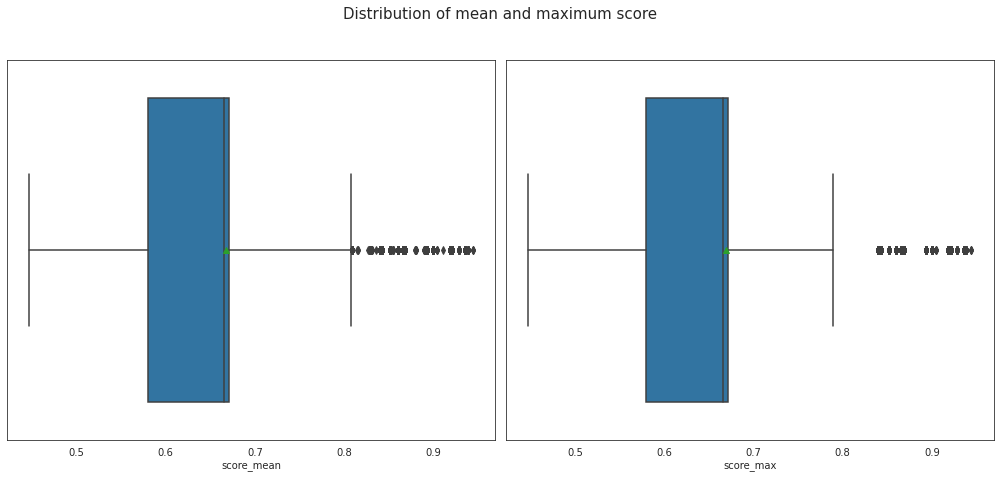

In [102]:

fig, axs = plt.subplots(1,2, sharey=False, figsize=(14,6))
axs = axs.flatten()

col = ['score_mean', 'score_max']
for ax, col in zip(axs, col):
  sns.boxplot(x=quotes[col], ax=ax, showmeans = True)
sns.set_style('white')

fig.suptitle("Distribution of mean and maximum score", y = 1.1, fontsize=15)
plt.subplots_adjust(top = 2)
fig.tight_layout()    
fig.set_figheight(6)
plt.savefig('/content/drive/MyDrive/ADAprojet2021/boxplot_mean_max_2020.png', bbox_inches='tight')
plt.show()

In [87]:
#We agreggate the scores by averaging the mean or the max.
score_speaker = pd.DataFrame()
score_speaker['mean'] = quotes.groupby('qids')['score_mean'].mean()
score_speaker['max'] = quotes.groupby('qids')['score_max'].mean()

#We change the name of the index to ensure the merge with the speaker dataframe
score_speaker.index.names = ['id']

#Merge the latter infromation with the dataFrame of the speakers.
speaker = pd.merge(speaker, score_speaker, on='id')

In [91]:
speaker

,id,label,gender,date_of_birth,nationality,US_congress_bio_ID,mean,max
0,Q19388,Dani Parejo,Q6581097,1989-01-01 00:00:00,False,False,0.651429,0.651429
1,Q19406,David Goffin,Q6581097,1990-01-01 00:00:00,False,False,0.637143,0.637143
2,Q19673,Al Gore,Q6581097,1948-01-01 00:00:00,True,True,0.665102,0.665102
3,Q19845,Geri Halliwell,Q6581072,1972-01-01 00:00:00,False,False,0.693333,0.693333
4,Q21759,Winnie Byanyima,Q6581072,1959-01-01 00:00:00,False,False,0.665714,0.665714
...,...,...,...,...,...,...,...,...
33852,Q208834,René Préval,Q6581097,1943-01-01 00:00:00,False,False,0.580000,0.580000
33853,Q209518,Wayne Gretzky,Q6581097,1961-01-01 00:00:00,True,False,0.657302,0.657302
33854,Q210172,Kevin Jonas,Q6581097,1987-01-01 00:00:00,True,False,0.580000,0.580000
33855,Q210462,Christina Hendricks,Q6581072,1975-01-01 00:00:00,True,False,0.665714,0.665714


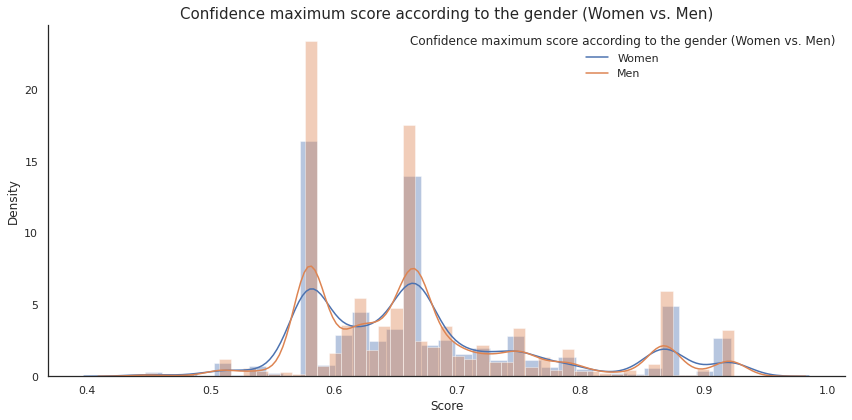

<Figure size 864x432 with 0 Axes>

In [141]:
#Distribution of the score with respect to gender:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(speaker[speaker.gender=="Q6581072" ]['max']) 
sns.distplot(speaker[speaker.gender=="Q6581097" ]['max']) 
sns.set_style('white')
plt.xlabel('Score')
plt.title("Confidence maximum score according to the gender (Women vs. Men)", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.legend(title="Confidence maximum score according to the gender (Women vs. Men)",  labels=['Women', 'Men'], frameon=False)

#Get rid of the top and right outlines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()
plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_max_gender_2020.png', bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Q6581072 v.s. Q6581097: t-test independent samples with Bonferroni correction, P_val=2.412e-02 stat=2.255e+00


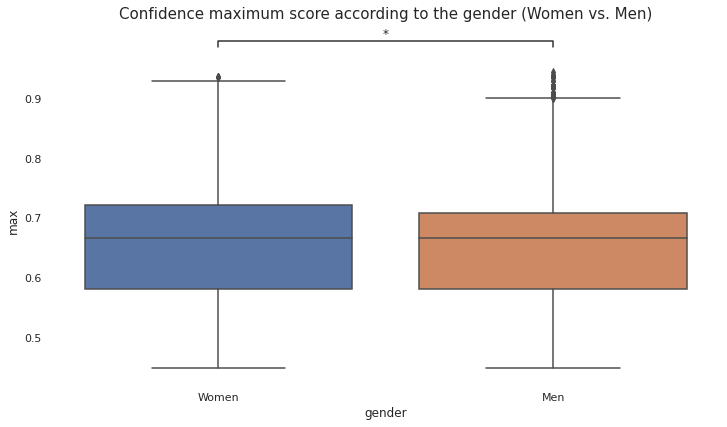

In [175]:
!pip install statannot
from statannot import add_stat_annotation

#sns.set_style("white")
sns.set(rc={'axes.facecolor':'white','figure.figsize':(12,6)})
ax = sns.boxplot(data=speaker, x='gender', y='max', order=["Q6581072", "Q6581097"])
ax.set_title("Confidence maximum score according to the gender (Women vs. Men)",y =1.1,fontdict= {'fontsize': 15})
ax.set(xticklabels=['Women', 'Men'])


add_stat_annotation(ax, data=speaker, x='gender', y='max', order=["Q6581072", "Q6581097"],
                    box_pairs=[("Q6581072", "Q6581097")],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)


plt.savefig('/content/drive/MyDrive/ADAprojet2021/boxplot_score_gender_stats_2020.png', bbox_inches='tight')
plt.show()


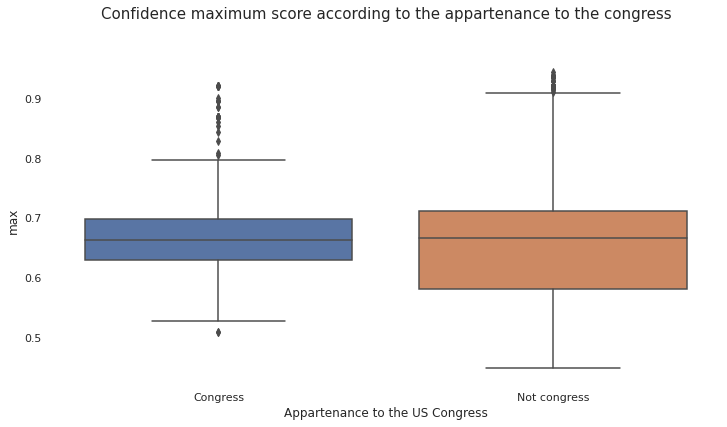

In [198]:
#sns.set_style("white")
sns.set(rc={'axes.facecolor':'white','figure.figsize':(12,6)})
ax = sns.boxplot(data=speaker, x='US_congress_bio_ID', y='max', order=[True, False])
ax.set_title("Confidence maximum score according to the appartenance to the congress",y =1.1,fontdict= {'fontsize': 15})
ax.set(xticklabels=['Congress', 'Not congress'])
ax.set(xlabel='Appartenance to the US Congress')

plt.savefig('/content/drive/MyDrive/ADAprojet2021/boxplot_score_gender_stats_2020.png', bbox_inches='tight')
plt.show()

In [190]:
val = ttest_ind( a = speaker[speaker.US_congress_bio_ID==True]['mean'], 
                      b = speaker[speaker.US_congress_bio_ID==False]['mean'], equal_var=False )

print("Considering the comparison of the mean score for US person belonging the congress or not.")
print("The t-statistic is:", val.statistic, ". The p-value is:", val.pvalue, ".")

Considering the comparison of the mean score for US person belonging the congress or not.
The t-statistic is: -0.26609594528306385 . The p-value is: 0.790265318549254 .


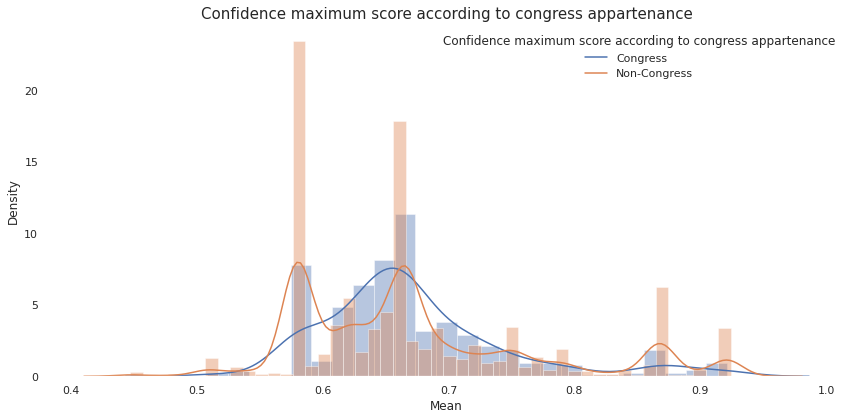

<Figure size 864x432 with 0 Axes>

In [203]:
#Distribution of the score with respect to the fact of belonging to the US Congress or not:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(speaker[speaker.US_congress_bio_ID == True]['max']) 
sns.distplot(speaker[speaker.US_congress_bio_ID == False]['max']) 
sns.set_style('white')
plt.xlabel('Mean')
plt.title("Confidence maximum score according to congress appartenance", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.legend(title="Confidence maximum score according to congress appartenance",  labels=['Congress', 'Non-Congress'], frameon=False)

#Get rid of the top and right outlines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_max_congress_2020.png', bbox_inches='tight')

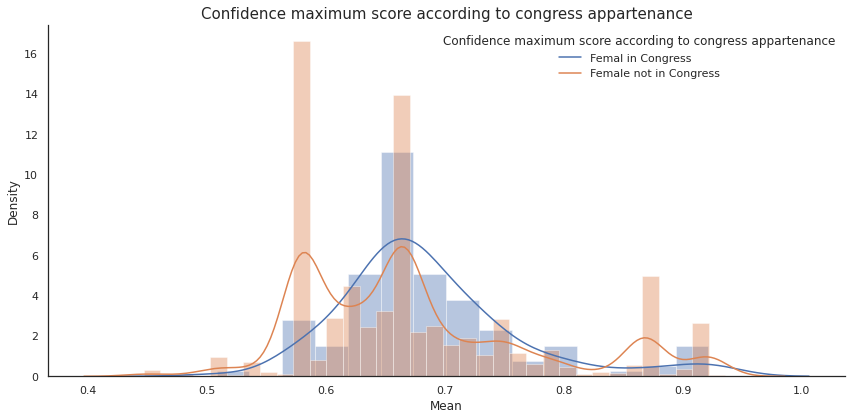

<Figure size 864x432 with 0 Axes>

In [193]:

#Histogram of the distribution of kilometrages (updated contracts):
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(speaker[(speaker.US_congress_bio_ID == True) & (speaker.gender=="Q6581072")]['max']) 
sns.distplot(speaker[(speaker.US_congress_bio_ID == False) & (speaker.gender=="Q6581072")]['max']) 
sns.set_style('white')
plt.xlabel('Score')
plt.title("Confidence maximum score according to congress appartenance", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.legend(title="Confidence maximum score according to congress appartenance",  labels=['Women in Congress', 'Women not in Congress'], frameon=False)

#Get rid of the top and right outlines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()
plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_female_congress_2020.png', bbox_inches='tight')

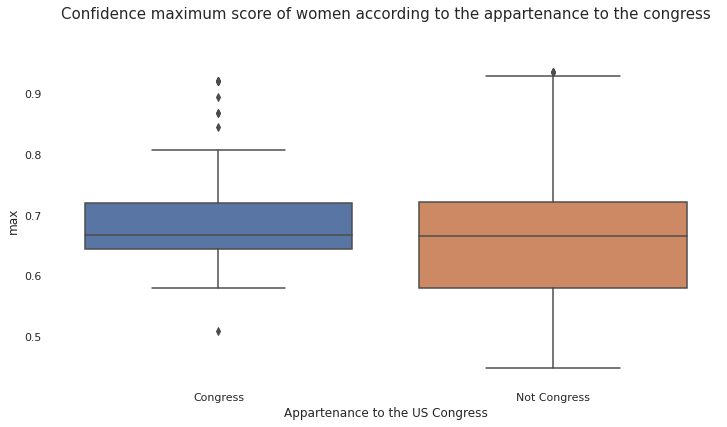

In [202]:

sns.set(rc={'axes.facecolor':'white','figure.figsize':(12,6)})
ax = sns.boxplot(data=speaker[speaker.gender == "Q6581072"], x='US_congress_bio_ID', y='max', order=[True, False])
ax.set_title("Confidence maximum score of women according to the appartenance to the congress",y =1.1,fontdict= {'fontsize': 15})
ax.set(xlabel='Appartenance to the US Congress')
ax.set(xticklabels=['Congress', 'Not Congress'])

plt.savefig('/content/drive/MyDrive/ADAprojet2021/boxplot_score_female_congress_stats_2020.png', bbox_inches='tight')
plt.show()

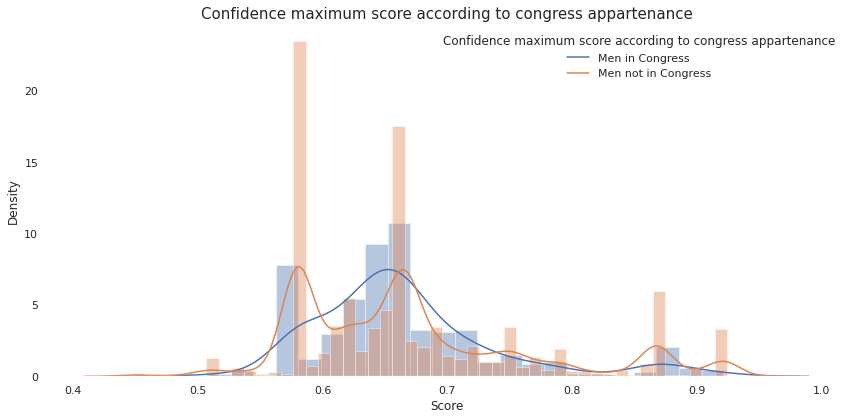

<Figure size 864x432 with 0 Axes>

In [199]:
#Histogram of the distribution of kilometrages (updated contracts):
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(speaker[(speaker.US_congress_bio_ID == True) & (speaker.gender=="Q6581097")]['max']) 
sns.distplot(speaker[(speaker.US_congress_bio_ID == False) & (speaker.gender=="Q6581097")]['max']) 
sns.set_style('white')
plt.xlabel('Score')
plt.title("Confidence maximum score according to congress appartenance", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.legend(title="Confidence maximum score according to congress appartenance",  labels=['Men in Congress', 'Men not in Congress'], frameon=False)

#Get rid of the top and right outlines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()
plt.savefig('/content/drive/MyDrive/ADAprojet2021/dist_male_congress_2020.png', bbox_inches='tight')

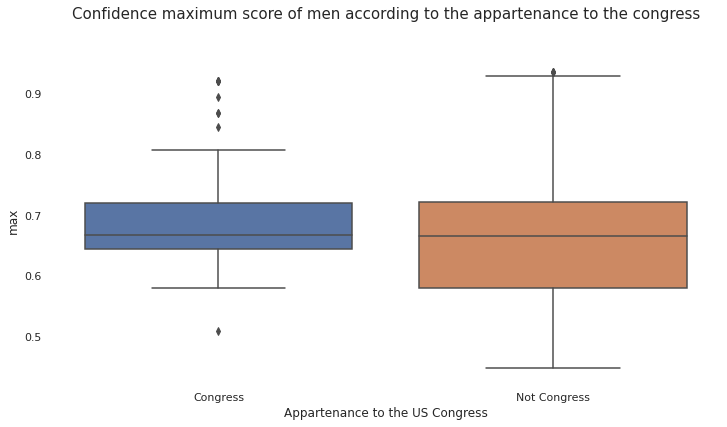

In [201]:

sns.set(rc={'axes.facecolor':'white','figure.figsize':(12,6)})
ax = sns.boxplot(data=speaker[speaker.gender == "Q6581072"], x='US_congress_bio_ID', y='max', order=[True, False])
ax.set_title("Confidence maximum score of men according to the appartenance to the congress",y =1.1,fontdict= {'fontsize': 15})
ax.set(xlabel='Appartenance to the US Congress')
ax.set(xticklabels=['Congress', 'Not Congress'])

plt.savefig('/content/drive/MyDrive/ADAprojet2021/boxplot_score_male_congress_stats_2020.png', bbox_inches='tight')
plt.show()

# to do list (avec ± l'ordre)

- ajouter les citations au passé MAEVA 🆗

- faire des chunks dataframe avec le set entier pour faire les manipulations dessus et stocker dans pickle
NAOMI

- choisir quelles expressions qu'on garde MAEVA 🆗

- comparaison avec la prise en compte du temps (deja codé) MAEVA 🆗

- aggreger les scores (mean/max) pour les comparaisons exactes.
MAEVA 🆗

- graph pour les deux types d'aggregats (distribution) 2 : ALEXY

- stats !! Mettre les deviations standards (MAEVA) MAEVA 🆗

- graphes des distributions des expressions exactement 
ALEXY

- faire les n-grams/ou chunks
FLORETTE

- distributions des elements les plus utilisés en general ALEXY

- faire les similarités FLORETTE

- definir un threshold de similarité : bon sens TOUS ~0.7

- aggreger les scores comme avant MAEVA

- merger avec les speakers
NAOMI

- faire les tests statistiques H/F MAEVA

- faire les tests statistiques avec les personnes du congrès  MAEVA

- faire les distributions des mots les plus utilisés/expressions les plus utilisées par les speakers les plus confidents (sentiment analysis si on a le temps ca serait cool) ALEXY

- faire un lien avec l'article et comparer a quel point resultats sont similaires à l'étude NAOMI

- Trouver des visualisations sympathiques (plotly) ALEXY
